In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import pandas as pd
PREDS = 'preds'

def load_output(path):
  with open(path, 'r') as f:
    loaded_json = json.load(f)
    df = pd.DataFrame.from_dict(loaded_json, orient='index', columns=[PREDS])
  
  print('Finish loading output.')
  return df

In [3]:
ROOT = '/content/drive/My Drive/nlp-data/'
COVID_OUTPUT = ROOT + 'covid-output.json'

covid_preds = load_output(COVID_OUTPUT)

Finish loading output.


In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import json

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('brown')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown

import re
import gensim
from gensim.utils import simple_preprocess

import math
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

class AnalyticsDataset(Dataset):

  def __init__(self, data_file, preds_df, maxlen):
    # Constants
    self.ID = 'id_str'
    self.TEXT = 'text'
    self.PARENT_ID = 'in_reply_to_status_id_str'
    self.PARENT_TWEET = 'text_x'
    self.REPLY_TWEETS = 'text_y'
    self.DATE = 'created_at'
    self.TOKENS = 'tokens'
    
    # Libraries
    self.lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    self.stopwords = stopwords.words('english')
    self.custom_stopwords = ['coronavirus', 'covid', 'amp']
    
    #words from brown corpus
    raw_brown_words = brown.words()
    brown_words = []
    for word in raw_brown_words:
      brown_words.append(word.lower())
    self.brown_words = brown_words

    # Create count_dict, total_word, total_unique_word from brown_corpus
    count_dict = {}
    total_word = 0
    total_unique_word = 0
    for word in self.brown_words:
        word = word.lower()
        if word not in count_dict:
            total_unique_word += 1
            count_dict[word] = 1
        else:
            count_dict[word] += 1
    for key in count_dict:
        total_word += count_dict[key]
    self.count_dict = count_dict
    self.total_word = total_word
    self.total_unique_word = total_unique_word

    # Predictions
    self.preds_df = preds_df

    # Open dataset
    self.dataset_df = pd.read_json(path_or_buf=data_file, lines=True) # returns a df where row = a collection of tweets, with each column = a single tweet

    self.maxlen = maxlen
  
  def get_date_created(self):
    df = self.preds_df.copy()
    df[self.DATE] = ""
    for index, row in self.dataset_df.iterrows():
      row_twt = self.dataset_df.iloc[index]
      for twt in row_twt:
        if twt[self.PARENT_ID] == None:
          date_created = twt[self.DATE]
          twt_id = twt[self.ID]
        break
      if twt_id in df.index:
        df.loc[twt_id, self.DATE] = date_created.lower()
      else:
        print("ID not found, abort..")
        return 0
    return df
  
  def preprocess_text(self, text):
    text = text.lower()
    temp = text.split()

    hashtag_dict = {}
    for index, word in enumerate(temp):
      if word.startswith('@'):
        text = text.replace(word, '')
      if word.startswith('#'):
        new_word = word[1:]
        text = text.replace(word, new_word)
        # tokens = self.max_match_or_rev(new_word, self.count_dict, self.total_word, self.total_unique_word)
        # tokens_str = ''
        # for token in tokens:
        #   tokens_str += token + ' '
        # text = text.replace(word, tokens_str)

    text_url = re.sub(r"http\S+", "", text)

    temp_lemma = text_url.split()
    for index, word in enumerate(temp_lemma):
      lemma = self.lemmatize(word)
      text_url = text_url.replace(word, lemma)
    return text_url

  def lemmatize(self, word):
    lemma = self.lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = self.lemmatizer.lemmatize(word,'n')
    return lemma

  def max_match(self, hashtag):
      tokens = []
      longest_index = 0
      while longest_index < len(hashtag):
          temp = ''
          lemma = ''
          longest_word = ''
          for i in range(longest_index,len(hashtag)):
              temp = hashtag[longest_index:i+1]
              lemma = self.lemmatize(temp)
              if lemma != temp or lemma in self.brown_words:
                  if lemma in self.brown_words:
                      longest_word = temp
          if len(longest_word) == 0:
              longest_word = hashtag[longest_index]
          longest_index += len(longest_word)
          tokens.append(longest_word)
      return tokens

  def rev_max_match(self, hashtag):
      tokens = []
      longest_index = len(hashtag) - 1
      while longest_index > -1:
          temp = ''
          lemma = ''
          longest_word = ''
          i = longest_index
          while i > -1:
              temp = hashtag[i:longest_index + 1]
              lemma = self.lemmatize(temp)
              if lemma != temp or lemma in self.brown_words:
                  if lemma in self.brown_words:
                      longest_word = temp
              i -= 1
          if len(longest_word) == 0:
              longest_word = hashtag[longest_index]
          longest_index -= len(longest_word)
          tokens.append(longest_word)
      tokens.reverse()
      return tokens
  
  def find_prob(self, tokens, count_dict, total_word, total_unique_word):
    # called in max_match_or_rev
    prob = 0
    for token in tokens:
        count = 0
        if token in count_dict:
            count = count_dict[token] + 1
        else:
            count += 1
        prob += math.log((count / (total_word + total_unique_word)))
    return prob

  def max_match_or_rev(self, hashtag, count_dict, total_word, total_unique_word):
    normal = self.max_match(hashtag)
    rev = self.rev_max_match(hashtag)

    if normal != rev: # MaxMatch and reversed MaxMatch differs
        normal_prob = self.find_prob(normal, count_dict, total_word, total_unique_word)
        rev_prob = self.find_prob(rev, count_dict, total_word, total_unique_word)
        if rev_prob > normal_prob:
          # print("rev")
          return rev
    return normal
  
  def tokenize(self, text):
    tokens = gensim.utils.simple_preprocess(text)

    clean_tokens = []
    for token in tokens:
      if token not in self.stopwords and token not in self.custom_stopwords:
        clean_tokens.append(token)
    
    return clean_tokens
  
  def get_tokens(self):
    df = self.preds_df.copy()
    df[self.TOKENS] = None
    for index, row in self.dataset_df.iterrows():
      row_twt = self.dataset_df.iloc[index]
      tokens = []
      for twt in row_twt:
        if twt == None:
          break
        text = twt[self.TEXT]
        preprocess = self.preprocess_text(text)
        tokens.append(self.tokenize(preprocess))
        if twt[self.PARENT_ID] == None:
          twt_id = twt[self.ID]
      if twt_id in df.index:
        df.loc[twt_id, self.TOKENS] = tokens
      else:
        print("ID not found, abort..")
        return 0
    return df
  
  def get_hashtags(self):
    df = self.preds_df.copy()
    df['h_parent'] = None
    df['h_replies'] = None
    
    for index, row in self.dataset_df.iterrows():
      row_twt = self.dataset_df.iloc[index]
      conc_hashtags = []
      for twt in row_twt:
        if twt == None:
          break
        # get hashtags
        hashtags = [tags[self.TEXT] for tags in twt['entities']['hashtags'] if twt['entities']['hashtags']]
        # print(hashtags)
        if twt[self.PARENT_ID] == None:
          twt_id = twt[self.ID]
          df.loc[twt_id, 'h_parent'] = hashtags
        if twt[self.PARENT_ID] != None:
          for tag in hashtags:
            conc_hashtags.append(tag)
      # print(conc_hashtags)
      df.loc[twt_id, 'h_replies'] = conc_hashtags
      # if twt_id in df.index:
      #   df.loc[twt_id, col_header] = hashtags
      # else:
      #   print("ID not found, abort..")
      #   return 0

    return df


  def get_stats(self):
    df = self.preds_df.copy()
    
    rumour_count = 0
    rumour_replies = 0
    non_rumour_count = 0
    non_rumour_replies = 0
    data_count = 0

    for index, row in self.dataset_df.iterrows():
      row_twt = self.dataset_df.iloc[index]
      replies = 0
      for twt in row_twt:
        if twt == None:
          break
        # get hashtags
        if twt[self.PARENT_ID] == None:
          twt_id = twt[self.ID]
        if twt[self.PARENT_ID] != None:
          replies += 1
      if twt_id in df.index:
        df.loc[twt_id, 'replies'] = replies
      else:
        print("ID not found, abort..")
        return 0

    for index, row in df.iterrows():
      data_count += 1
      if row['preds'] == 'rumour':
        rumour_count += 1
        rumour_replies += row['replies']

      elif row['preds'] == 'non-rumour':
        non_rumour_count += 1
        non_rumour_replies += row['replies']

    return rumour_count, non_rumour_count, data_count, rumour_replies, non_rumour_replies
  
  def get_month(self):
    r_mth = {}
    nr_mth = {}

    date_created_df = self.get_date_created()
    for index, row in date_created_df.iterrows():
      mth = row['created_at'].split()[1]
      label = row['preds']
      if label == 'rumour':
        if mth not in r_mth:
          r_mth[mth] = 1
        else:
          r_mth[mth] += 1
      else:
        if mth not in nr_mth:
          nr_mth[mth] = 1
        else:
          nr_mth[mth] += 1
    
    return r_mth, nr_mth

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [5]:
COVID_SET = ROOT + 'covid.data.jsonl'
MAXLEN = 512

covid_set = AnalyticsDataset(data_file = COVID_SET, preds_df = covid_preds, maxlen = MAXLEN)

In [6]:
tokens_set = covid_set.get_tokens()
print(tokens_set)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


                          preds                                             tokens
1272262651100434433      rumour  [[accord, new, york, times, warner, bros, want...
1287153210990395392  non-rumour  [[hurricane, hanna, make, landfall, texas, sto...
1266555444283179008  non-rumour     [[monkey, loose, india, steal, blood, sample]]
1257715199655755779  non-rumour  [[eastleigh, swahili, arab, mombasa, sky, rock...
1274338812173393920  non-rumour  [[trump, felt, comfortable, comfortable, say, ...
...                         ...                                                ...
1249502859185590272  non-rumour  [[wonder, many, live, could, save, trump, focu...
1284050414619459586  non-rumour  [[front, page, th, march, first, line, reads, ...
1274505289614725122  non-rumour  [[trump, complete, racism, trifecta, three, mi...
1267884642637676545  non-rumour  [[photograph, today, division, proceed, pandem...
1265801718958301184  non-rumour  [[gone, bill, de, blasio, say, nyc, face, bill...

[17

In [7]:
ROOT = '/content/drive/My Drive/nlp-data/'
OUTPUT = ROOT + 'covid_tokens.json'

tokens_dct = {}

for index, row in tokens_set.iterrows():
  tokens_dct[index] = (row['preds'], row['tokens'])

with open(OUTPUT, 'w') as out:
  json.dump(tokens_dct, out)
print('Finish output to json.')

Finish output to json.


Hashtags Analysis

In [8]:
hashtag_df = covid_set.get_hashtags()

r_tag_count = 0
nr_tag_count = 0
r_tag_dict = {}
nr_tag_dict = {}

r_corpus = ''
nr_corpus = ''

for index, row in hashtag_df.iterrows():
  if row['preds'] == 'rumour':
    for tag in row['h_parent']:
      r_corpus += tag + ' '
      r_tag_count += 1
      if tag not in r_tag_dict:
        r_tag_dict[tag] = 1
      else:
        r_tag_dict[tag] += 1
    for tag in row['h_replies']:
      r_corpus += tag + ' '
      r_tag_count += 1
      if tag not in r_tag_dict:
        r_tag_dict[tag] = 1
      else:
        r_tag_dict[tag] += 1
  else:
    for tag in row['h_parent']:
      nr_tag_count += 1
      nr_corpus += tag + ' '
      if tag not in nr_tag_dict:
        nr_tag_dict[tag] = 1
      else:
        nr_tag_dict[tag] += 1
    for tag in row['h_replies']:
      nr_tag_count += 1
      nr_corpus += tag + ' '
      if tag not in nr_tag_dict:
        nr_tag_dict[tag] = 1
      else:
        nr_tag_dict[tag] += 1

r_sorted = {k: v for k, v in sorted(r_tag_dict.items(), key=lambda x: x[1], reverse=True)}
nr_sorted = {k: v for k, v in sorted(nr_tag_dict.items(), key=lambda x: x[1], reverse=True)}

print(r_sorted)
print(nr_sorted)
print(r_tag_count)
print(nr_tag_count)

{'COVID19': 1061, 'coronavirus': 530, 'covid19': 113, 'Coronavirus': 99, 'Covid19': 92, 'WuhanVirus': 79, 'CoronaVirus': 46, 'COVIDー19': 46, 'CoronavirusPandemic': 43, 'BREAKING': 43, 'Covid_19': 42, 'Trump': 35, 'China': 33, 'COVID': 31, 'TrumpVirus': 23, 'StayHome': 22, 'pandemic': 22, 'SecondWave': 19, 'CCP': 18, 'CoronavirusOutbreak': 18, 'ChinaVirus': 17, 'ChinaLiedPeopleDied': 16, 'ChineseVirus': 16, 'COVIDIOTS': 16, 'Florida': 15, 'Wuhan': 14, 'COVID__19': 14, 'COVID2019': 14, 'COVID19PH': 12, 'CCPVirus': 12, 'USA': 12, 'FakeNews': 12, 'COVID19Nigeria': 11, 'TakeResponsibility': 11, 'trump': 11, 'WearAMask': 10, 'auspol': 10, 'china': 10, 'Covid19SA': 10, 'Hydroxychloroquine': 10, 'SocialDistancing': 9, 'Trump2020': 9, 'TraitorTrump': 9, 'CoronavirusInSA': 9, 'CORONAVIRUS': 9, 'COVID19Pandemic': 9, 'SARSCoV2': 9, 'Cummings': 9, 'MAGA': 8, 'CoronaVirusSA': 8, 'CoronaVirusUpdate': 8, 'covid': 7, 'TrumpLiesAmericansDie': 7, 'CoronavirusUSA': 7, 'Brazil': 7, 'BorisJohnson': 7, 'Indi

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [r_corpus, nr_corpus]
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
print(x.shape)

df = pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names()).transpose().to_dict()
# print(df)

r_df = [k for k, v in sorted(df[1].items(), key=lambda x: x[1], reverse=True)]
print(r_df)

nr_df = [k for k, v in sorted(df[0].items(), key=lambda x: x[1], reverse=True)]
print(nr_df)

(2, 25311)
['covid19', 'coronavirus', 'trump', 'coronaviruspandemic', 'trumpvirus', 'wuhanvirus', 'covid_19', 'maga', 'covidー19', 'covid', 'trumpliesamericansdie', 'china', 'trumpliespeopledie', 'covidiots', 'usa', 'pandemic', 'trumpgenocide', 'trumpownseverydeath', 'donaldtrump', 'stayhome', 'biden2020', 'trump2020', 'blacklivesmatter', 'fakenews', 'gop', 'contest', 'trumpisanationaldisgrace', 'coronavirusoutbreak', 'covid2019', 'lockdown', 'chinavirus', 'chinesevirus', 'trumpisa_danger_toamerica', 'corona', 'trumphasnoplan', 'covidiot', 'socialdistancing', 'tmobiletuesdays', 'getusppe', 'trumpisaloser', 'trumpisanidiot', 'bunkerboy', 'covid__19', 'foxnews', 'who', 'wearamask', 'liarinchief', 'trumppandemic', 'failureinchief', 'hydroxychloroquine', 'stayathome', 'gopbetrayedamerica', 'healthcareheroes', 'trumpmeltdown', 'itelsaysstaysafe', 'kag', 'america', 'dumptrump2020', 'trumpfailedamerica', 'traitortrump', 'trumpresignnow', 'trumpliedpeopledied', 'americans', 'votebluetosaveameri

Temporal analysis

In [10]:
date_created_df = covid_set.get_date_created()
print(date_created_df)

                          preds                      created_at
1272262651100434433      rumour  sun jun 14 20:20:28 +0000 2020
1287153210990395392  non-rumour  sat jul 25 22:30:14 +0000 2020
1266555444283179008  non-rumour  sat may 30 02:22:04 +0000 2020
1257715199655755779  non-rumour  tue may 05 16:54:05 +0000 2020
1274338812173393920  non-rumour  sat jun 20 13:50:23 +0000 2020
...                         ...                             ...
1249502859185590272  non-rumour  mon apr 13 01:01:10 +0000 2020
1284050414619459586  non-rumour  fri jul 17 09:00:50 +0000 2020
1274505289614725122  non-rumour  sun jun 21 00:51:54 +0000 2020
1267884642637676545  non-rumour  tue jun 02 18:23:49 +0000 2020
1265801718958301184  non-rumour  thu may 28 00:27:01 +0000 2020

[17458 rows x 2 columns]


In [11]:
r_mth = {}
nr_mth = {}

for index, row in date_created_df.iterrows():
  mth = row['created_at'].split()[1]
  label = row['preds']
  if label == 'rumour':
    if mth not in r_mth:
      r_mth[mth] = 1
    else:
      r_mth[mth] += 1
  else:
    if mth not in nr_mth:
      nr_mth[mth] = 1
    else:
      nr_mth[mth] += 1

print(r_mth)
print(nr_mth)

{'jun': 329, 'jul': 205, 'mar': 227, 'may': 327, 'apr': 358, 'feb': 10, 'aug': 5, 'jan': 5}
{'jul': 1759, 'may': 4063, 'jun': 3182, 'apr': 4486, 'mar': 2271, 'feb': 180, 'aug': 24, 'jan': 27}


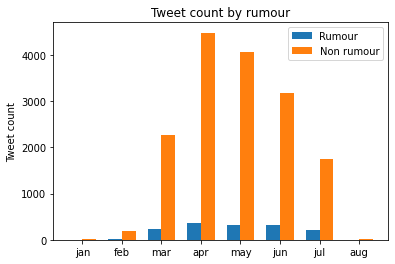

In [12]:
import matplotlib.pylab as plt
import numpy as np
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# r_sorted = sorted(r_mth.items(),key =lambda x:months.index(x[0]))
r_sorted = {k: v for k, v in sorted(r_mth.items(), key=lambda x:months.index(x[0]))}
nr_sorted = {k: v for k, v in sorted(nr_mth.items(), key=lambda x:months.index(x[0]))}

labels = [month for month in months if month in r_sorted.keys()]
x = np.arange(len(labels))
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, r_sorted.values(), width, label='Rumour')
rects2 = ax.bar(x + width/2, nr_sorted.values(), width, label='Non rumour')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweet count')
ax.set_title('Tweet count by rumour')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

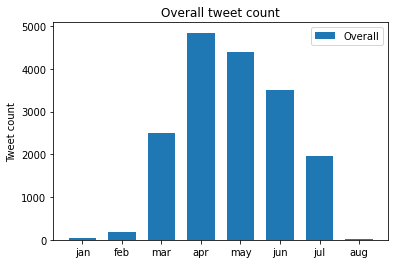

In [13]:
total_sorted = {}
for k, v in nr_sorted.items():
  total_sorted[k] = nr_sorted[k] + r_sorted[k]

labels = [month for month in months if month in r_sorted.keys()]
x = np.arange(len(labels))
width = 0.7  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, total_sorted.values(), width, label='Overall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweet count')
ax.set_title('Overall tweet count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()